In [ ]:
# Setup access to my Google Drive
from google.colab import drive
drive.mount('/content/drive',  force_remount=False)

# Set the working directory
import os
os.chdir('/content/drive/MyDrive/ext/RoadAccident/')
import warnings
warnings.filterwarnings("ignore")

Mounted at /content/drive


### 1. Obtaining and Viewing the Data
<a id='1. Obtaining and Viewing the Data'></a>

In [ ]:
# import the usual suspects ...
import pandas as pd
import numpy as np
import glob

import matplotlib.pyplot as plt
import seaborn as sns
# import classifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras import utils
from sklearn import preprocessing
from tensorflow.keras.layers import Dense, Input, Flatten, Dropout, Conv1D, MaxPooling1D, Concatenate, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, TimeDistributed, Bidirectional, LSTM, SimpleRNN
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!ls

 0c06d2998f3f2174b0a4781bd2a1c1ec.pdf  'ML709 PROJECT'
 Accident_Information.csv	       'ML709 Project-Draft Report.docx'
 CNN_model.csv			        New_ML709.ipynb
 hybrid_model.csv		        New_ML709_unbalanced.ipynb
 img				        perf_results.csv
 LSTM_model.csv			       'Predicting Accident_RNN_CNN.ipynb'
'ML709 Draft.pdf'		        RNN_model.csv
 ML709_Final_Copy.ipynb		       'short risk.pdf'
'ML709 Final Copy.pdf'		        Vehicle_Information.csv


> **Accidents**

In [ ]:
accidents = pd.read_csv('Accident_Information.csv', encoding='latin-1')
print('Records:', accidents.shape[0], '\nColumns:', accidents.shape[1])
accidents.head()

Records: 2047256 
Columns: 34


,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Police_Force,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland
0,200501BS00001,A,3218.0,NaN,0.0,Serious,None,2005-01-04,Tuesday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,17:42,Urban,Raining no high winds,2005,No
1,200501BS00002,B,450.0,C,0.0,Slight,None,2005-01-05,Wednesday,1.0,...,Metropolitan Police,Dry,Dual carriageway,None,30.0,17:36,Urban,Fine no high winds,2005,No
2,200501BS00003,C,0.0,NaN,0.0,Slight,None,2005-01-06,Thursday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30.0,00:15,Urban,Fine no high winds,2005,No
3,200501BS00004,A,3220.0,NaN,0.0,Slight,None,2005-01-07,Friday,1.0,...,Metropolitan Police,Dry,Single carriageway,None,30.0,10:35,Urban,Fine no high winds,2005,No
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,None,2005-01-10,Monday,1.0,...,Metropolitan Police,Wet or damp,Single carriageway,None,30.0,21:13,Urban,Fine no high winds,2005,No


In [ ]:
#accidents.info()

In [ ]:
#accidents.describe().T

In [ ]:
#accidents.isna().sum()

**Vehicles**

In [ ]:
vehicles = pd.read_csv('Vehicle_Information.csv', encoding='latin-1')
print('Records:', vehicles.shape[0], '\nColumns:', vehicles.shape[1])
vehicles.head()

Records: 2177205 
Columns: 24


,Accident_Index,Age_Band_of_Driver,Age_of_Vehicle,Driver_Home_Area_Type,Driver_IMD_Decile,Engine_Capacity_.CC.,Hit_Object_in_Carriageway,Hit_Object_off_Carriageway,Journey_Purpose_of_Driver,Junction_Location,...,Skidding_and_Overturning,Towing_and_Articulation,Vehicle_Leaving_Carriageway,Vehicle_Location.Restricted_Lane,Vehicle_Manoeuvre,Vehicle_Reference,Vehicle_Type,Was_Vehicle_Left_Hand_Drive,X1st_Point_of_Impact,Year
0,200401BS00001,26 - 35,3.0,Urban area,4.0,1588.0,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,Data missing or out of range,Front,2004
1,200401BS00002,26 - 35,NaN,Urban area,3.0,NaN,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,109,Data missing or out of range,Front,2004
2,200401BS00003,26 - 35,4.0,Data missing or out of range,NaN,998.0,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Turning right,1,109,Data missing or out of range,Front,2004
3,200401BS00003,66 - 75,NaN,Data missing or out of range,NaN,NaN,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,2,109,Data missing or out of range,Front,2004
4,200401BS00004,26 - 35,1.0,Urban area,4.0,124.0,None,None,Data missing or out of range,Data missing or out of range,...,None,No tow/articulation,Did not leave carriageway,0.0,Going ahead other,1,Motorcycle 125cc and under,Data missing or out of range,Front,2004


In [ ]:
accidents['Date']= pd.to_datetime(accidents['Date'], format="%Y-%m-%d")

# check
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2047256 entries, 0 to 2047255
Data columns (total 34 columns):
 #   Column                                       Dtype         
---  ------                                       -----         
 0   Accident_Index                               object        
 1   1st_Road_Class                               object        
 2   1st_Road_Number                              float64       
 3   2nd_Road_Class                               object        
 4   2nd_Road_Number                              float64       
 5   Accident_Severity                            object        
 6   Carriageway_Hazards                          object        
 7   Date                                         datetime64[ns]
 8   Day_of_Week                                  object        
 9   Did_Police_Officer_Attend_Scene_of_Accident  float64       
 10  Junction_Control                             object        
 11  Junction_Detail                      

Next, let's define a new column that groups the `Time` the accidents happened into one of five options:


In [ ]:
# slice first and second string from time column
accidents['Hour'] = accidents['Time'].str[0:2]

# convert new column to numeric datetype
accidents['Hour'] = pd.to_numeric(accidents['Hour'])

# drop null values in our new column
accidents = accidents.dropna(subset=['Hour'])

# cast to integer values
accidents['Hour'] = accidents['Hour'].astype('int')

In [ ]:
accidents.head()

,Accident_Index,1st_Road_Class,1st_Road_Number,2nd_Road_Class,2nd_Road_Number,Accident_Severity,Carriageway_Hazards,Date,Day_of_Week,Did_Police_Officer_Attend_Scene_of_Accident,...,Road_Surface_Conditions,Road_Type,Special_Conditions_at_Site,Speed_limit,Time,Urban_or_Rural_Area,Weather_Conditions,Year,InScotland,Hour
0,200501BS00001,A,3218.0,NaN,0.0,Serious,None,2005-01-04,Tuesday,1.0,...,Wet or damp,Single carriageway,None,30.0,17:42,Urban,Raining no high winds,2005,No,17
1,200501BS00002,B,450.0,C,0.0,Slight,None,2005-01-05,Wednesday,1.0,...,Dry,Dual carriageway,None,30.0,17:36,Urban,Fine no high winds,2005,No,17
2,200501BS00003,C,0.0,NaN,0.0,Slight,None,2005-01-06,Thursday,1.0,...,Dry,Single carriageway,None,30.0,00:15,Urban,Fine no high winds,2005,No,0
3,200501BS00004,A,3220.0,NaN,0.0,Slight,None,2005-01-07,Friday,1.0,...,Dry,Single carriageway,None,30.0,10:35,Urban,Fine no high winds,2005,No,10
4,200501BS00005,Unclassified,0.0,NaN,0.0,Slight,None,2005-01-10,Monday,1.0,...,Wet or damp,Single carriageway,None,30.0,21:13,Urban,Fine no high winds,2005,No,21


In [ ]:
# define a function that turns the hours into daytime groups
def when_was_it(hour):
    if hour >= 5 and hour < 10:
        return "1"
    elif hour >= 10 and hour < 15:
        return "2"
    elif hour >= 15 and hour < 19:
        return "3"
    elif hour >= 19 and hour < 23:
        return "4"
    else:
        return "5"

In [ ]:
# create a little dictionary to later look up the groups I created
daytime_groups = {1: 'Morning: Between 5 and 10', 
                  2: 'Office Hours: Between 10 and 15', 
                  3: 'Afternoon Rush: Between 15 and 19', 
                  4: 'Evening: Between 19 and 23', 
                  5: 'Night: Between 23 and 5'}

In [ ]:
# apply this function to our temporary hour column
accidents['Daytime'] = accidents['Hour'].apply(when_was_it)
accidents[['Time', 'Hour', 'Daytime']].head()

,Time,Hour,Daytime
0,17:42,17,3
1,17:36,17,3
2,00:15,0,5
3,10:35,10,2
4,21:13,21,4


In [ ]:
# drop old time column and temporary hour column
accidents = accidents.drop(columns=['Time', 'Hour'])

#### 2.2. Handling Missing Values
<a id='2.2. Handling Missing Values'></a>

In [ ]:
print('Proportion of Missing Values in Accidents Table:', 
      round(accidents.isna().sum().sum()/len(accidents), 3),)

Proportion of Missing Values in Accidents Table: 0.495


In [ ]:
# drop columns we don't need
accidents = accidents.drop(columns=['2nd_Road_Class', '2nd_Road_Number', 'Did_Police_Officer_Attend_Scene_of_Accident',
                                    'Location_Easting_OSGR', 'Location_Northing_OSGR', 
                                    'Longitude', 'Latitude', 'LSOA_of_Accident_Location',
                                    'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities',
                                    'InScotland'])

# drop remaining records with NaN's
accidents = accidents.dropna()

# check if we have no NaN's anymore
accidents.isna().sum().sum()

0

In [ ]:
print('Proportion of Missing Values in Vehicles Table:', 
      round(vehicles.isna().sum().sum()/len(vehicles),3))

Proportion of Missing Values in Vehicles Table: 0.938


In [ ]:
#vehicles.isna().sum()


#### 2.3. Merging Dataframes
<a id='2.3. Merging Dataframes'></a>

In [ ]:
# combine the accidents with the vehicles table
df = pd.merge(accidents[['Accident_Index', 'Accident_Severity', 'Daytime', 'Speed_limit', 'Urban_or_Rural_Area']], 
              vehicles[['Accident_Index', 'Age_Band_of_Driver', 'Age_of_Vehicle', 'Sex_of_Driver', 
                        'Engine_Capacity_.CC.', 'Vehicle_Manoeuvre']], 
              on='Accident_Index')

df.isna().sum()

Accident_Index               0
Accident_Severity            0
Daytime                      0
Speed_limit                  0
Urban_or_Rural_Area          0
Age_Band_of_Driver           0
Age_of_Vehicle          337900
Sex_of_Driver                0
Engine_Capacity_.CC.    250266
Vehicle_Manoeuvre            0
dtype: int64

In [ ]:
df = df.dropna()
df.isna().sum().sum()

0

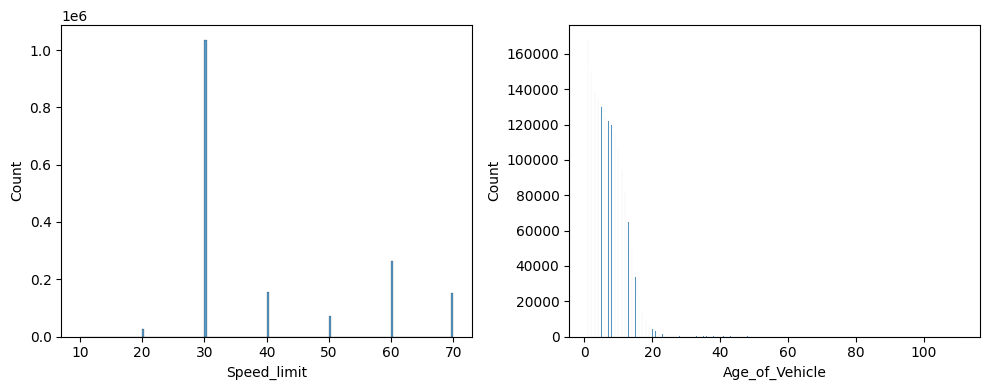

In [ ]:
# Check the distribution of numeric columns
fig, axs = plt.subplots(1,2, figsize=(10, 4))
sns.histplot(df['Speed_limit'], ax=axs[0])
sns.histplot(df['Age_of_Vehicle'], ax=axs[1])
plt.tight_layout()
plt.show()

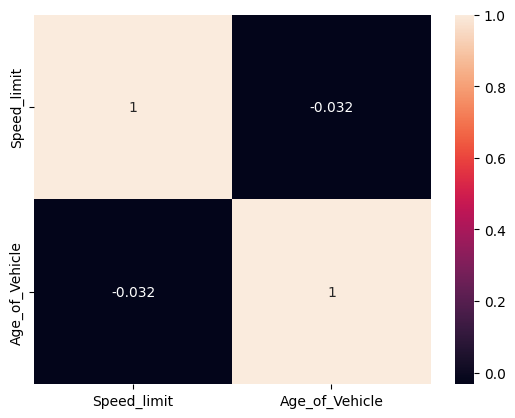

In [ ]:
# Check the correlation between numeric columns
sns.heatmap(df[['Speed_limit', 'Age_of_Vehicle']].corr(), annot=True)
plt.show()


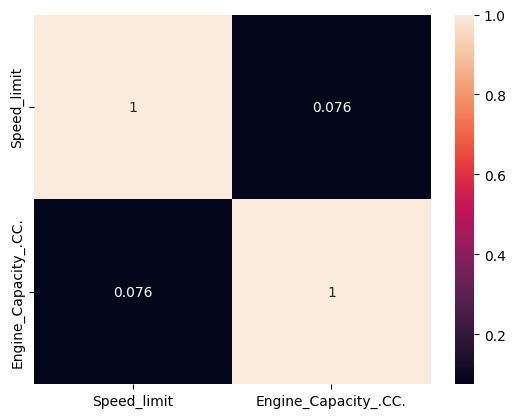

In [ ]:
# Check the correlation between numeric columns
sns.heatmap(df[['Speed_limit', 'Engine_Capacity_.CC.']].corr(), annot=True)
plt.show()


In [ ]:
df.describe()

,Speed_limit,Age_of_Vehicle,Engine_Capacity_.CC.
count,1.704137e+06,1.704137e+06,1.704137e+06
mean,3.982653e+01,7.113811e+00,2.034436e+03
std,1.460574e+01,4.706823e+00,1.909883e+03
min,1.000000e+01,1.000000e+00,1.000000e+00
25%,3.000000e+01,3.000000e+00,1.299000e+03
50%,3.000000e+01,7.000000e+00,1.598000e+03
75%,5.000000e+01,1.000000e+01,1.997000e+03
max,7.000000e+01,1.110000e+02,9.600000e+04


In [ ]:

df.info()    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704137 entries, 0 to 2058195
Data columns (total 10 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Accident_Index        object 
 1   Accident_Severity     object 
 2   Daytime               object 
 3   Speed_limit           float64
 4   Urban_or_Rural_Area   object 
 5   Age_Band_of_Driver    object 
 6   Age_of_Vehicle        float64
 7   Sex_of_Driver         object 
 8   Engine_Capacity_.CC.  float64
 9   Vehicle_Manoeuvre     object 
dtypes: float64(3), object(7)
memory usage: 143.0+ MB


In [ ]:
# cast categorical features - currently stored as string data - to their proper data format
for col in ['Accident_Severity', 'Daytime', 'Speed_limit', 'Urban_or_Rural_Area',
            'Age_Band_of_Driver', 'Sex_of_Driver', 'Vehicle_Manoeuvre']:
    df[col] = df[col].astype('category')
    
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1704137 entries, 0 to 2058195
Data columns (total 10 columns):
 #   Column                Dtype   
---  ------                -----   
 0   Accident_Index        object  
 1   Accident_Severity     category
 2   Daytime               category
 3   Speed_limit           category
 4   Urban_or_Rural_Area   category
 5   Age_Band_of_Driver    category
 6   Age_of_Vehicle        float64 
 7   Sex_of_Driver         category
 8   Engine_Capacity_.CC.  float64 
 9   Vehicle_Manoeuvre     category
dtypes: category(7), float64(2), object(1)
memory usage: 63.4+ MB



<a id='2.4. Handling Numerical Data'></a>

*Detecting Outliers*

In [ ]:
# define numerical columns
num_cols = ['Age_of_Vehicle', 'Engine_Capacity_.CC.']

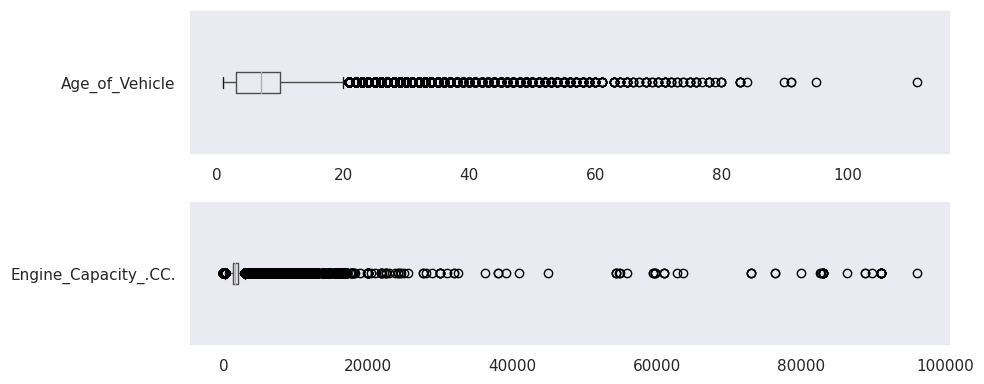

In [ ]:
# plotting boxplots
sns.set(style='darkgrid')
fig, axes = plt.subplots(2,1, figsize=(10,4))

for ax, col in zip(axes, num_cols):
    df.boxplot(column=col, grid=False, vert=False, ax=ax)
    plt.tight_layout();

*Handling Outliers*

In [ ]:
df.describe()

,Age_of_Vehicle,Engine_Capacity_.CC.
count,1.704137e+06,1.704137e+06
mean,7.113811e+00,2.034436e+03
std,4.706823e+00,1.909883e+03
min,1.000000e+00,1.000000e+00
25%,3.000000e+00,1.299000e+03
50%,7.000000e+00,1.598000e+03
75%,1.000000e+01,1.997000e+03
max,1.110000e+02,9.600000e+04


In [ ]:
# phrasing condition
condition = (df['Engine_Capacity_.CC.'] < 20000)

# keep only records that meet the condition and don't fall within extreme outliers
df = df[condition]

Vehicle Feature

In [ ]:
age_of_vehicle_bins = {1: '1 to <2 years', 
                       2: '2 to <3 years', 
                       3: '3 to <7 years', 
                       4: '7 to <10 years', 
                       5: '>=10 years'}

In [ ]:
# arguments in bins parameter denote left edge of each bin
df['Age_of_Vehicle'] = np.digitize(df['Age_of_Vehicle'], bins=[1,2,3,7,10])

# convert into categorical column
df['Age_of_Vehicle'] = df['Age_of_Vehicle'].astype('category')

# check the count within each bucket
df['Age_of_Vehicle'].value_counts().sort_index()

1    167816
2    150202
3    529340
4    356331
5    500364
Name: Age_of_Vehicle, dtype: int64

In [ ]:
# re-define numerical feature columns - only one left
num_cols = ['Engine_Capacity_.CC.']

In [ ]:
df.head()

,Accident_Index,Accident_Severity,Daytime,Speed_limit,Urban_or_Rural_Area,Age_Band_of_Driver,Age_of_Vehicle,Sex_of_Driver,Engine_Capacity_.CC.,Vehicle_Manoeuvre
0,200501BS00002,Slight,3,30.0,Urban,36 - 45,3,Male,8268.0,Slowing or stopping
1,200501BS00003,Slight,5,30.0,Urban,26 - 35,3,Male,8300.0,Going ahead right-hand bend
2,200501BS00004,Slight,2,30.0,Urban,46 - 55,3,Female,1769.0,Going ahead other
3,200501BS00005,Slight,4,30.0,Urban,46 - 55,5,Male,85.0,Going ahead other
4,200501BS00006,Slight,2,30.0,Urban,46 - 55,1,Male,2976.0,Moving off



<a id='2.5. Handling Categorical Data'></a>

In [ ]:
# define categorical feature columns
cat_cols = ['Daytime', 'Speed_limit', 'Urban_or_Rural_Area',
            'Age_Band_of_Driver', 'Age_of_Vehicle', 'Sex_of_Driver', 'Vehicle_Manoeuvre']

# define target col
target_col = ['Accident_Severity']

cols = cat_cols + num_cols + target_col

# copy dataframe - just to be safe
df_model = df[cols].copy()
df_model.shape

(1704053, 9)

*Encoding categorical features*

In [ ]:
# create dummy variables from the categorical features
dummies = pd.get_dummies(df_model[cat_cols], drop_first=True)

In [ ]:
df_model = pd.concat([df_model[num_cols], df_model[target_col], dummies], axis=1)
df_model.shape

(1704053, 51)

In [ ]:
df_model.isna().sum().sum()

0

In [ ]:
df_model.head()

,Engine_Capacity_.CC.,Accident_Severity,Daytime_2,Daytime_3,Daytime_4,Daytime_5,Speed_limit_15.0,Speed_limit_20.0,Speed_limit_30.0,Speed_limit_40.0,...,Vehicle_Manoeuvre_Overtaking static vehicle - offside,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go - held up,Vehicle_Manoeuvre_Waiting to turn left,Vehicle_Manoeuvre_Waiting to turn right
0,8268.0,Slight,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
1,8300.0,Slight,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1769.0,Slight,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,85.0,Slight,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2976.0,Slight,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_model['Accident_Severity'].unique()

['Slight', 'Serious', 'Fatal']
Categories (3, object): ['Fatal', 'Serious', 'Slight']

In [ ]:
# Create a target column with numeric data
className = ['Slight', 'Serious', 'Fatal']
df_model['labels'] = df_model['Accident_Severity'].replace({'Slight': 0, 'Serious': 1, 'Fatal':2})
df_model.drop(['Accident_Severity'], axis = 1, inplace = True)
df_model.head()

,Engine_Capacity_.CC.,Daytime_2,Daytime_3,Daytime_4,Daytime_5,Speed_limit_15.0,Speed_limit_20.0,Speed_limit_30.0,Speed_limit_40.0,Speed_limit_50.0,...,Vehicle_Manoeuvre_Parked,Vehicle_Manoeuvre_Reversing,Vehicle_Manoeuvre_Slowing or stopping,Vehicle_Manoeuvre_Turning left,Vehicle_Manoeuvre_Turning right,Vehicle_Manoeuvre_U-turn,Vehicle_Manoeuvre_Waiting to go - held up,Vehicle_Manoeuvre_Waiting to turn left,Vehicle_Manoeuvre_Waiting to turn right,labels
0,8268.0,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
1,8300.0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1769.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,85.0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2976.0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
sum(df_model['labels']==0)

1464234

In [ ]:
class_counts = df_model['labels'].value_counts()
class_counts

0    1464234
1     216801
2      23018
Name: labels, dtype: int64

In [ ]:
# Identify the class with the most samples
majority_class = df_model['labels'].value_counts().idxmax()

# Determine the number of samples to drop
n_to_drop = int((df_model['labels'].value_counts().max() - sum(df_model['labels'] == 1))/2)

# Randomly sample the required number of samples from the majority class
df_to_drop = df_model.loc[df_model['labels'] == 0].sample(n=n_to_drop, random_state=42)

# Drop the sampled rows from the original dataframe
df_balanced = df_model.drop(df_to_drop.index)

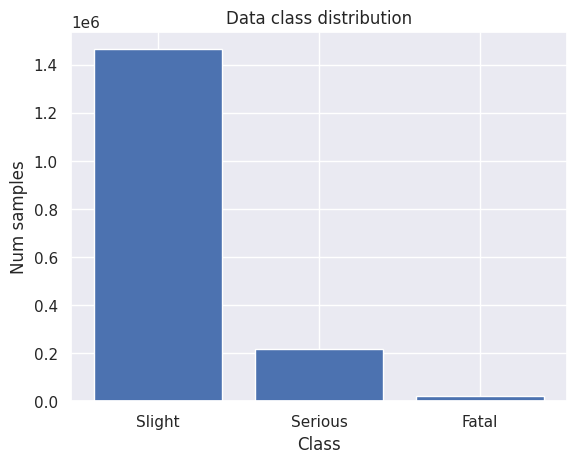

In [ ]:
def vis_data_class_distribution(labels, class_names):
    counts = [sum(labels == c) for c in range(len(class_names))]
    plt.title(f'Data class distribution')
    plt.bar(class_names, counts)
    plt.xlabel('Class')
    plt.ylabel('Num samples')
    plt.show()
vis_data_class_distribution(df_model['labels'],  className)

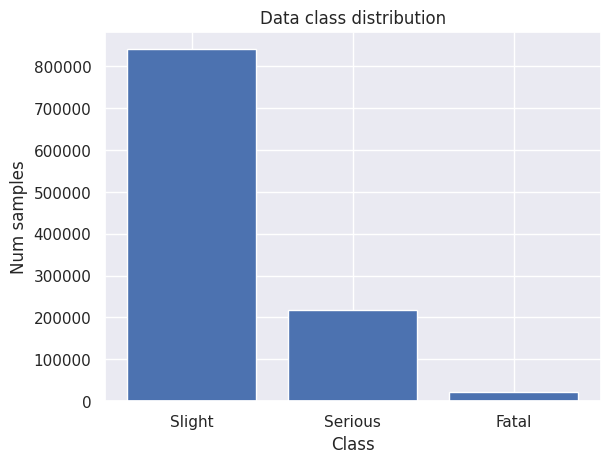

In [ ]:
vis_data_class_distribution(df_balanced['labels'],  className)


### 3. Modeling the Data
<a id='3. Modeling the Data'></a>

#### 3.1. Train-Test-Split
<a id='3.1. Train-Test-Split'></a>

In [ ]:
# define our features 
features = df_balanced.drop(['labels'], axis=1).values
# define our target
target = df_balanced['labels'].values

In [ ]:
# standardize the data
sclr = preprocessing.StandardScaler()
features = sclr.fit_transform(features)

In [ ]:
from sklearn.model_selection import train_test_split

# split our data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

#### Feature Visualization using tSNE plot

In [ ]:
def as_masks(arr):
    n_classes = arr.max()+1
    one_hot = np.eye(n_classes)[arr]
    return [m == 1 for m in one_hot.T]

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
PlotFeatures = tsne.fit_transform(X_test_f)

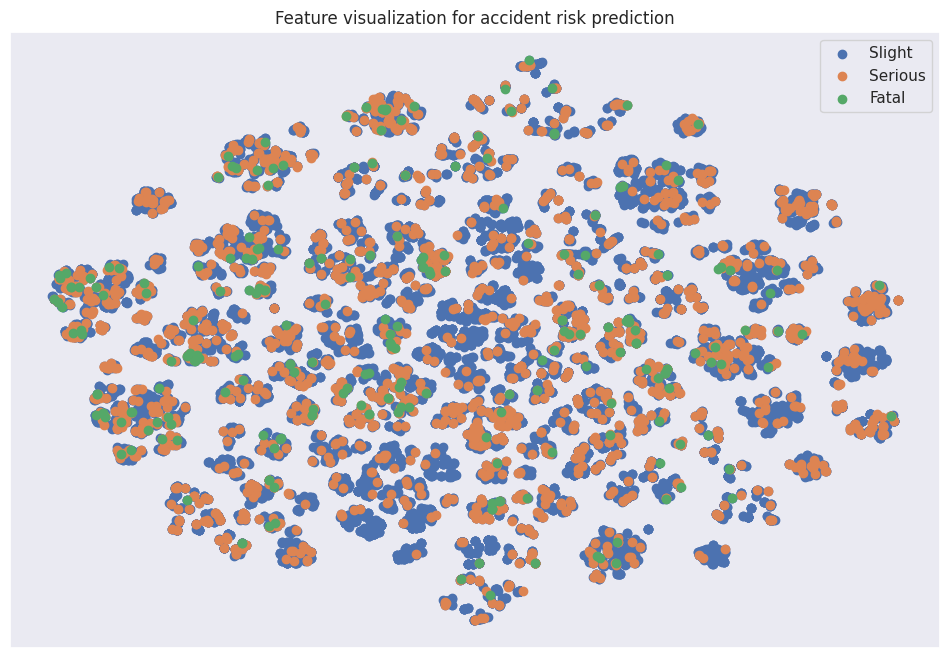

In [ ]:
masks = as_masks(np.array(y_test_f))
fig = plt.figure(figsize = (12,8))
ax = fig.add_subplot(1, 1, 1)
for i, mask in enumerate(masks):
    cls = className[i]
    ax.scatter(PlotFeatures[mask][:, 0], PlotFeatures[mask][:, 1], label=cls)
leg = ax.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
ax.set_title('Feature visualization for accident risk prediction')
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.show()

#### 3.2. Handling Imbalanced Classes
<a id='3.2. Handling Imbalanced Classes'></a>

If we have a target vector with highly imbalanced classes ...

In [ ]:
df_model['labels'].value_counts(normalize=True)

0    0.859266
1    0.127227
2    0.013508
Name: labels, dtype: float64

In [ ]:
# compute class weights
class_weights = compute_class_weight(class_weight  = 'balanced', classes  = np.unique(y_train), y = y_train)

# convert class weights to dictionary
class_weight_dict =  dict(zip(np.unique(y_train), class_weights))
class_weight_dict

{0: 0.428405869514679, 1: 1.6613305345551077, 2: 15.664709187464883}

In [ ]:
def disp_conf_matrix(cm, class_names = className):
    cm = cm.astype(np.float32) / cm.sum(axis=1)[:, None]
    df_cm = pd.DataFrame(cm, class_names, class_names)
    ax = sns.heatmap(df_cm, annot=True, cmap='flare')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.show()

def perf_m(y_true, y_pred, modelName):
    acc  = accuracy_score(y_true, y_pred) * 100
    prec = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    rec = recall_score(y_true, y_pred, average='weighted')
    disp_conf_matrix(confusion_matrix(y_true, y_pred), class_names = className)

    return pd.DataFrame({'Modelname':[modelName], 'Accuracy':acc, 'Precision': prec, 'F1 score':f1, 'Recall':rec})



# Training the models

## 1. Random Forest

In [ ]:
# # instantiate RandomForestClassifier with entropy and class_weight
# rf = RandomForestClassifier(random_state=4, criterion='entropy', n_jobs=-1, class_weight='balanced')

# # train
# rf.fit(X_train, y_train)

# # predict
# ypreds  = rf.predict(X_test)

In [ ]:
# perf_rf = perf_m(y_test, ypreds, 'RF Classifier')
# perf_rf

## 2. CNN Training

In [ ]:
num_classes = 3

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
y_train_nn = label_encoder.fit_transform(y_train)
y_test_nn = label_encoder.fit_transform(y_test)
y_train_ann = utils.to_categorical(y_train_nn, num_classes)
y_test_ann = utils.to_categorical(y_test_nn, num_classes)
X_test = X_test.reshape(-1, 50, 1)
X_train = X_train.reshape(-1, 50, 1)

In [ ]:
# Build the CNN model
model = Sequential([
          Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
          MaxPooling1D(pool_size=2),
          Conv1D(filters=32, kernel_size=3, activation='relu'),
          MaxPooling1D(pool_size=2),
          Flatten(),
          Dense(10, activation='relu'),
          Dense(3, activation = 'softmax')
          ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 48, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 32)            12320     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 32)           0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 352)               0         
                                                                 
 dense (Dense)               (None, 10)                3

In [ ]:
table=pd.DataFrame(columns=["Layer Name", "Type", "Output Shape","Param #"])
for layer in model.layers:
    table = table.append({"Layer Name":layer.name, "Type": layer.__class__.__name__,"Output Shape":layer.output_shape, "Param #": layer.count_params()}, ignore_index=True)
table.to_csv('CNN_model.csv')

In [ ]:
# Train the lstm-transformer model (on GPU)
opt = Adam(learning_rate=0.0001)
with tf.device('/device:GPU:0'):
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    history_cnn = model.fit(X_train, y_train_ann, epochs=40, validation_split = 0.15, batch_size=100, verbose=1)

Epoch 1/40
7347/7347 [==============================] - 38s 4ms/step - loss: 0.5810 - accuracy: 0.7756 - val_loss: 0.5719 - val_accuracy: 0.7773
Epoch 2/40
7347/7347 [==============================] - 27s 4ms/step - loss: 0.5684 - accuracy: 0.7781 - val_loss: 0.5701 - val_accuracy: 0.7772
Epoch 3/40
7347/7347 [==============================] - 27s 4ms/step - loss: 0.5671 - accuracy: 0.7781 - val_loss: 0.5688 - val_accuracy: 0.7773
Epoch 4/40
7347/7347 [==============================] - 27s 4ms/step - loss: 0.5658 - accuracy: 0.7783 - val_loss: 0.5682 - val_accuracy: 0.7774
Epoch 5/40
7347/7347 [==============================] - 27s 4ms/step - loss: 0.5649 - accuracy: 0.7787 - val_loss: 0.5676 - val_accuracy: 0.7782
Epoch 6/40
7347/7347 [==============================] - 27s 4ms/step - loss: 0.5642 - accuracy: 0.7789 - val_loss: 0.5676 - val_accuracy: 0.7782
Epoch 7/40
7347/7347 [==============================] - 27s 4ms/step - loss: 0.5639 - accuracy: 0.7791 - val_loss: 0.5671 - val_ac

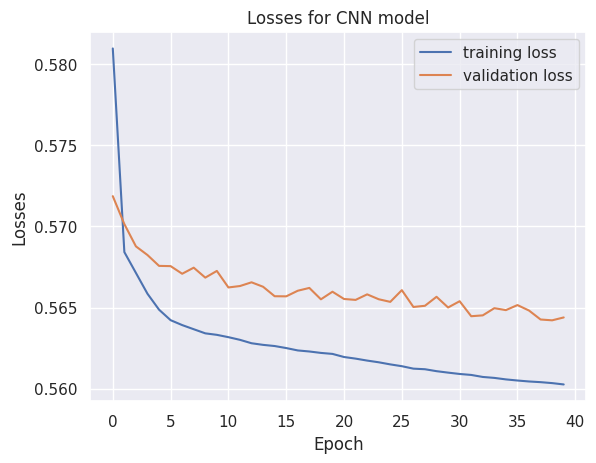

In [ ]:
#PLot training and validation losses
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Losses for CNN model')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

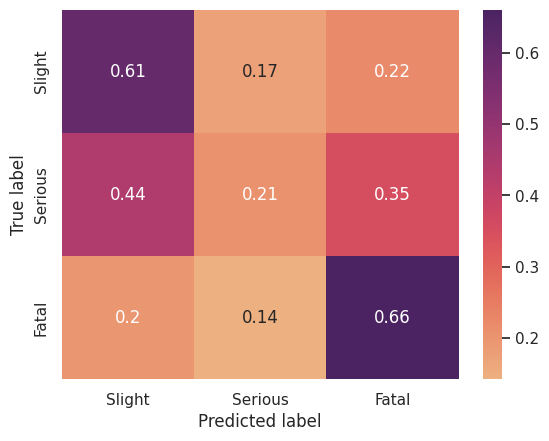

,Modelname,Accuracy,Precision,F1 score,Recall
0,CNN,77.997205,0.715184,0.697109,0.779972


In [ ]:
# Evaluate the CNN model
ypred = model.predict(X_test)
perf_cnn = perf_m(y_test, np.argmax(ypred, axis=1), 'CNN')
perf_cnn

## 3. LSTM

In [ ]:
X_train.shape[1]

50

In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(128, input_shape=(50, 1)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3,activation = 'softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 70,787
Trainable params: 70,787
Non-trainable params: 0
_________________________________________________________________


In [ ]:
table=pd.DataFrame(columns=["Layer Name", "Type", "Output Shape","Param #"])
for layer in model.layers:
    table = table.append({"Layer Name":layer.name, "Type": layer.__class__.__name__,"Output Shape":layer.output_shape, "Param #": layer.count_params()}, ignore_index=True)
table.to_csv('LSTM_model.csv')

In [ ]:
# Train the lstm model (on GPU)
opt = Adam(learning_rate=0.0001)
with tf.device('/device:GPU:0'):
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    history_lstm= model.fit(X_train, y_train_ann, epochs=40, validation_split = 0.15, batch_size=100, verbose=1)

Epoch 1/40
7347/7347 [==============================] - 43s 5ms/step - loss: 0.6038 - accuracy: 0.7780 - val_loss: 0.5864 - val_accuracy: 0.7774
Epoch 2/40
7347/7347 [==============================] - 40s 5ms/step - loss: 0.5870 - accuracy: 0.7782 - val_loss: 0.5808 - val_accuracy: 0.7774
Epoch 3/40
7347/7347 [==============================] - 39s 5ms/step - loss: 0.5812 - accuracy: 0.7782 - val_loss: 0.5805 - val_accuracy: 0.7774
Epoch 4/40
7347/7347 [==============================] - 39s 5ms/step - loss: 0.5787 - accuracy: 0.7782 - val_loss: 0.5763 - val_accuracy: 0.7774
Epoch 5/40
7347/7347 [==============================] - 40s 5ms/step - loss: 0.5764 - accuracy: 0.7784 - val_loss: 0.5743 - val_accuracy: 0.7774
Epoch 6/40
7347/7347 [==============================] - 39s 5ms/step - loss: 0.5741 - accuracy: 0.7783 - val_loss: 0.5721 - val_accuracy: 0.7775
Epoch 7/40
7347/7347 [==============================] - 39s 5ms/step - loss: 0.5715 - accuracy: 0.7784 - val_loss: 0.5717 - val_ac

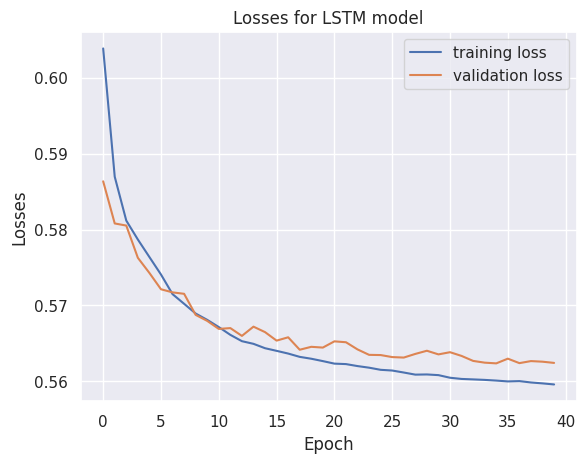

In [ ]:
#PLot training and validation losses
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Losses for LSTM model')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

432/432 [==============================] - 2s 4ms/step


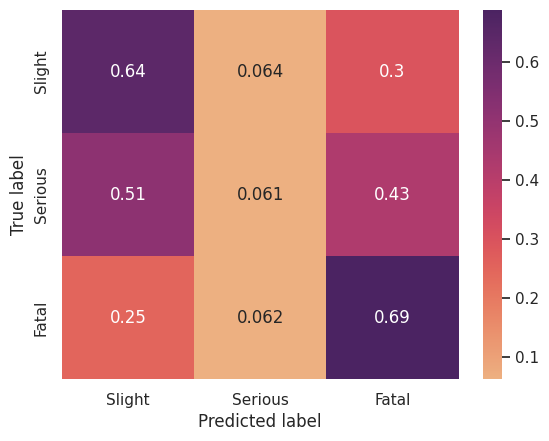

,Modelname,Accuracy,Precision,F1 score,Recall
0,LSTM,78.084677,0.719824,0.699164,0.780847


In [ ]:
# Evaluate the lstm model
ypred = model.predict(X_test)
perf_lstm = perf_m(y_test, np.argmax(ypred, axis=1), 'LSTM')
perf_lstm

## 3. RNN

In [ ]:
# Build the RNN model
model = Sequential([
          SimpleRNN(32, input_shape=(None, 1)),
          Dropout(0.2),
          Dense(32, activation='relu'),
          Dense(3, activation = 'softmax')
          ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,243
Trainable params: 2,243
Non-trainable params: 0
_________________________________________________________________


In [ ]:
table=pd.DataFrame(columns=["Layer Name", "Type", "Output Shape","Param #"])
for layer in model.layers:
    table = table.append({"Layer Name":layer.name, "Type": layer.__class__.__name__,"Output Shape":layer.output_shape, "Param #": layer.count_params()}, ignore_index=True)
table.to_csv('RNN_model.csv')

In [ ]:
# Train the lstm-transformer model (on GPU)
opt = Adam(learning_rate=0.0001)
with tf.device('/device:GPU:0'):
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    history_rnn = model.fit(X_train, y_train_ann, epochs=20, validation_split = 0.15, batch_size=100, verbose=1)

Epoch 1/20
7347/7347 [==============================] - 166s 22ms/step - loss: 0.6122 - accuracy: 0.7707 - val_loss: 0.5904 - val_accuracy: 0.7774
Epoch 2/20
7347/7347 [==============================] - 164s 22ms/step - loss: 0.5816 - accuracy: 0.7782 - val_loss: 0.5775 - val_accuracy: 0.7774
Epoch 3/20
7347/7347 [==============================] - 164s 22ms/step - loss: 0.5751 - accuracy: 0.7782 - val_loss: 0.5742 - val_accuracy: 0.7774
Epoch 4/20
7347/7347 [==============================] - 164s 22ms/step - loss: 0.5724 - accuracy: 0.7782 - val_loss: 0.5728 - val_accuracy: 0.7774
Epoch 5/20
7347/7347 [==============================] - 164s 22ms/step - loss: 0.5705 - accuracy: 0.7782 - val_loss: 0.5716 - val_accuracy: 0.7774
Epoch 6/20
7347/7347 [==============================] - 163s 22ms/step - loss: 0.5693 - accuracy: 0.7783 - val_loss: 0.5718 - val_accuracy: 0.7774
Epoch 7/20
7347/7347 [==============================] - 163s 22ms/step - loss: 0.5685 - accuracy: 0.7786 - val_loss: 0

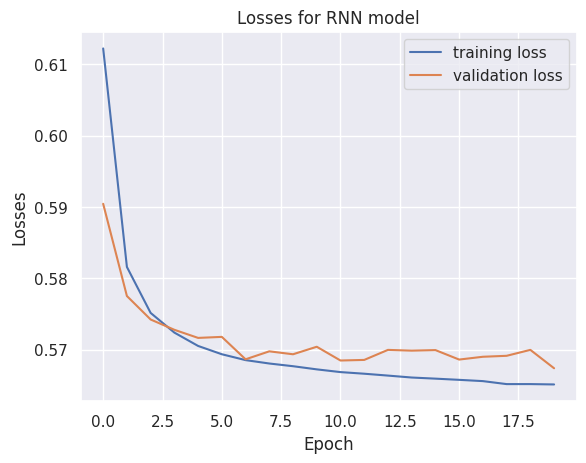

In [ ]:
#PLot training and validation losses
plt.plot(history_rnn.history['loss'])
plt.plot(history_rnn.history['val_loss'])
plt.title('Losses for RNN model')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

432/432 [==============================] - 3s 7ms/step


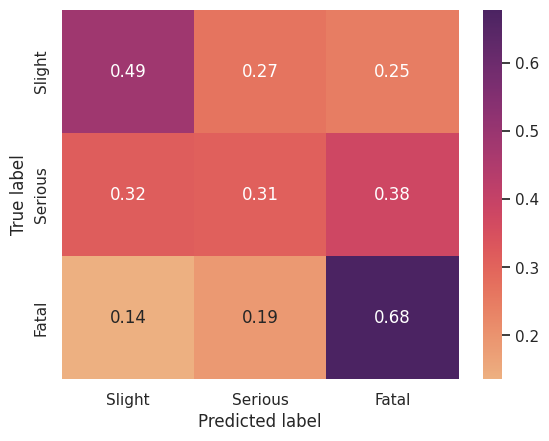

,Modelname,Accuracy,Precision,F1 score,Recall
0,RNN,77.98656,0.715354,0.697455,0.779866


In [ ]:
# Evaluate the RNN model
ypred = model.predict(X_test)
perf_rnn = perf_m(y_test, np.argmax(ypred, axis=1), 'RNN')
perf_rnn

## LSTM-Transformer

In [ ]:
# Define input shape
input_layer = Input(shape=(X_train.shape[1], 1))

# LSTM layer
lstm_layer = LSTM(units=64, return_sequences=True)(input_layer)

# Transformer encoder layer
transformer_layer = MultiHeadAttention(num_heads=4, key_dim=32)(lstm_layer, lstm_layer)
transformer_layer = LayerNormalization(epsilon=1e-6)(transformer_layer)

# Concatenate LSTM output and Transformer output
concat_layer = Concatenate()([lstm_layer, transformer_layer])

# Global average pooling and dropout layers
pooling_layer = GlobalAveragePooling1D()(concat_layer)
dropout_layer = Dropout(rate=0.1)(pooling_layer)

# Output layer
output_layer = Dense(units=3, activation='softmax')(dropout_layer)

# Create and compile model
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 1)]      0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 50, 64)       16896       ['input_1[0][0]']                
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 64)      33216       ['lstm_1[0][0]',                 
 dAttention)                                                      'lstm_1[0][0]']                 
                                                                                                  
 layer_normalization (LayerNorm  (None, 50, 64)      128         ['multi_head_attention[0][0]'

In [ ]:
table=pd.DataFrame(columns=["Layer Name", "Type", "Output Shape","Param #"])
for layer in model.layers:
    table = table.append({"Layer Name":layer.name, "Type": layer.__class__.__name__,"Output Shape":layer.output_shape, "Param #": layer.count_params()}, ignore_index=True)
table.to_csv('hybrid_model.csv')

In [ ]:
# Train the lstm-transformer model (on GPU)
opt = Adam(learning_rate=0.0001)
with tf.device('/device:GPU:0'):
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=opt)
    history_hybrid = model.fit(X_train, y_train_ann, epochs=20, validation_split = 0.15, batch_size=100, verbose=1)

Epoch 1/20
7347/7347 [==============================] - 57s 7ms/step - loss: 0.5919 - accuracy: 0.7781 - val_loss: 0.5874 - val_accuracy: 0.7774
Epoch 2/20
7347/7347 [==============================] - 52s 7ms/step - loss: 0.5830 - accuracy: 0.7782 - val_loss: 0.5845 - val_accuracy: 0.7773
Epoch 3/20
7347/7347 [==============================] - 52s 7ms/step - loss: 0.5800 - accuracy: 0.7782 - val_loss: 0.5853 - val_accuracy: 0.7776
Epoch 4/20
7347/7347 [==============================] - 52s 7ms/step - loss: 0.5785 - accuracy: 0.7783 - val_loss: 0.5794 - val_accuracy: 0.7774
Epoch 5/20
7347/7347 [==============================] - 52s 7ms/step - loss: 0.5772 - accuracy: 0.7785 - val_loss: 0.5786 - val_accuracy: 0.7779
Epoch 6/20
7347/7347 [==============================] - 52s 7ms/step - loss: 0.5759 - accuracy: 0.7786 - val_loss: 0.5801 - val_accuracy: 0.7776
Epoch 7/20
7347/7347 [==============================] - 52s 7ms/step - loss: 0.5750 - accuracy: 0.7788 - val_loss: 0.5776 - val_ac

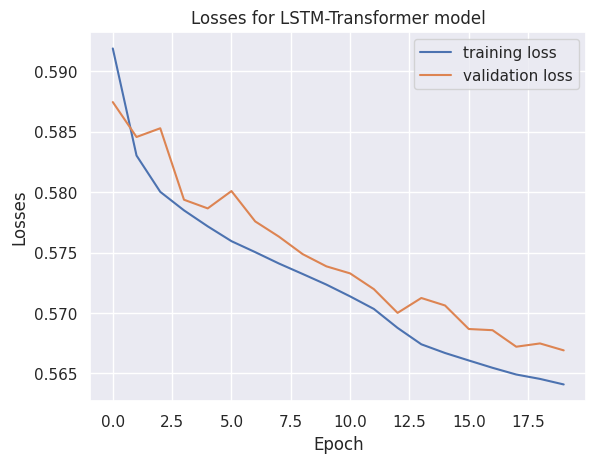

In [ ]:
#PLot training and validation losses
plt.plot(history_hybrid.history['loss'])
plt.plot(history_hybrid.history['val_loss'])
plt.title('Losses for LSTM-Transformer model')
plt.ylabel('Losses')
plt.xlabel('Epoch')
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.show()

432/432 [==============================] - 2s 3ms/step


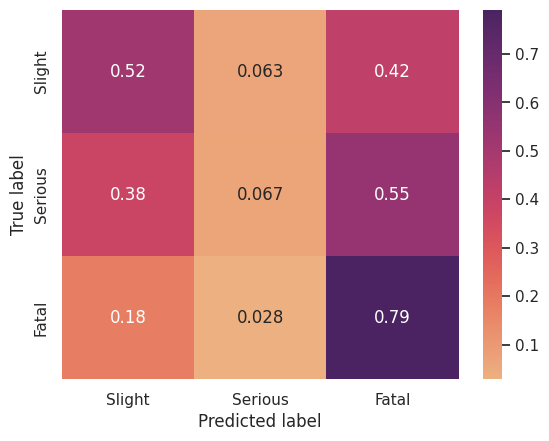

,Modelname,Accuracy,Precision,F1 score,Recall
0,Hybrid (LSTM-Transformer,78.008312,0.714362,0.700699,0.780083


In [ ]:
# Evaluate the Hybrid model
ypred = model.predict(X_test)
perf_hybrid = perf_m(y_test, np.argmax(ypred, axis=1), 'Hybrid (LSTM-Transformer')
perf_hybrid

# Merge performance metrics from all the models

In [ ]:
results = pd.concat((perf_cnn, perf_lstm, perf_rnn, perf_hybrid), axis = 0)
results

,Modelname,Accuracy,Precision,F1 score,Recall
0,CNN,77.997205,0.715184,0.697109,0.779972
0,LSTM,78.084677,0.719824,0.699164,0.780847
0,RNN,77.986560,0.715354,0.697455,0.779866
0,Hybrid (LSTM-Transformer,78.008312,0.714362,0.700699,0.780083


In [ ]:
results.to_csv('perf_results.csv')